### Обучение модели градиентного бустинга -- CatBoost


In [1]:
import sqlite3
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import pickle
import ipywidgets

In [2]:
from catboost import Pool, CatBoostRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error

In [3]:
conn = sqlite3.connect('db\cian.db') 
          
df = pd.read_sql_query ('''
                               SELECT *
                               FROM ad_data_cleaned_with_fixed_age
                               ''', conn)

In [4]:
# создание выходной (целевой) переменной
y = df.price
# создание входных переменных
X = df.drop('price', axis = 1)
# разбиение выбоки на тренировочную и тестовую в пропорции 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)


In [5]:
# размеры выборок
print(f"Размеры выборок \nX_train: {len(X_train)},\nX_test: {len(X_test)},\ny_train: {len(y_train)},\ny_test: {len(y_test)}")

Размеры выборок 
X_train: 66925,
X_test: 16732,
y_train: 66925,
y_test: 16732


In [5]:
# категориальные признаки
categorical_features = df.select_dtypes(include=['object']).columns.tolist()

In [6]:
train_pool = Pool(data=X_train, label=y_train, cat_features=categorical_features)
test_pool = Pool(data=X_test, label=y_test, cat_features=categorical_features)

In [7]:
model = CatBoostRegressor(loss_function='RMSE', eval_metric='MAE', learning_rate=0.2, iterations=1000, metric_period=50, early_stopping_rounds=20)

In [20]:
model.fit(train_pool, eval_set=test_pool, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 21014810.4038704	test: 20737006.4323843	best: 20737006.4323843 (0)	total: 173ms	remaining: 2m 52s
50:	learn: 6638237.3257347	test: 6695575.6325213	best: 6695575.6325213 (50)	total: 6.17s	remaining: 1m 54s
100:	learn: 6080431.9570329	test: 6303273.4417885	best: 6302604.6929655 (99)	total: 12.1s	remaining: 1m 48s
150:	learn: 5737524.6180476	test: 6106373.2956568	best: 6106373.2956568 (150)	total: 18.9s	remaining: 1m 46s
200:	learn: 5461497.5686475	test: 5938251.1018990	best: 5938251.1018990 (200)	total: 26.1s	remaining: 1m 43s
250:	learn: 5235381.6925417	test: 5829757.9839048	best: 5829757.9839048 (250)	total: 32.5s	remaining: 1m 36s
300:	learn: 5070335.5720276	test: 5751038.7232606	best: 5751038.7232606 (300)	total: 38.7s	remaining: 1m 29s
350:	learn: 4889096.1402931	test: 5677215.5466838	best: 5675690.4211743 (348)	total: 46.6s	remaining: 1m 26s
400:	learn: 4745061.0540397	test: 5607168.9757807	best: 5607168.9757807 (400)	total: 52.7s	remaining: 1m 18s
450:	learn: 4615681.443

In [21]:
pred = model.predict(test_pool)

In [22]:
print('R^2:', r2_score(y_test, pred))
print('MAE: ', mean_absolute_error(y_test, pred))

R^2: 0.8944305277466743
MAE:  5196603.858592113


Модель CatBoost показала большую эффективность по сравнению с моделью градиентного бустинга из sklearn, но не достигла точности ранее обученной модели Random Forest (R^2: 0.90, MAE:  4701742).

Text(0.5, 0, 'CatBoost Feature Importance')

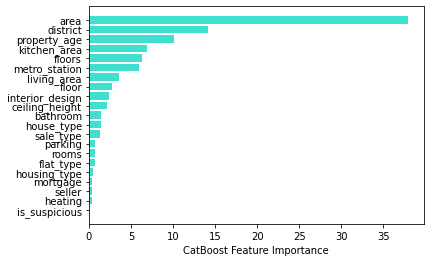

In [25]:
# важность признаков
sorted_feature_importance = model.feature_importances_.argsort()
plt.barh(X.columns[sorted_feature_importance], 
        model.feature_importances_[sorted_feature_importance], 
        color='turquoise')
plt.xlabel("CatBoost Feature Importance")

In [28]:
# сохранение модели
with open('fitted_models/catboost.pkl', 'wb') as f:
    pickle.dump(model, f)

CatBoost с подбором гиперпараметров при помощи Random Search

In [8]:
model_cb = CatBoostRegressor(loss_function='RMSE', eval_metric='MAE')

In [9]:
parameters = {'depth': [6, 8, 10], 'learning_rate': [0.05, 0.1, 0.2], 'l2_leaf_reg': [1, 3, 5,], 'iterations': [200, 500, 1000], 'early_stopping_rounds': [50]}

In [10]:
grid = model_cb.randomized_search(parameters, train_pool, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 30233344.4124587	test: 30539601.3953268	best: 30539601.3953268 (0)	total: 365ms	remaining: 1m 12s
1:	learn: 28725530.3237424	test: 29043759.9112838	best: 29043759.9112838 (1)	total: 493ms	remaining: 48.8s
2:	learn: 27292235.1655482	test: 27623504.3120407	best: 27623504.3120407 (2)	total: 636ms	remaining: 41.8s
3:	learn: 25932406.3954043	test: 26273696.8724621	best: 26273696.8724621 (3)	total: 744ms	remaining: 36.4s
4:	learn: 24644295.4024922	test: 24989233.8756656	best: 24989233.8756656 (4)	total: 864ms	remaining: 33.7s
5:	learn: 23418530.7146187	test: 23765447.3261664	best: 23765447.3261664 (5)	total: 1.01s	remaining: 32.5s
6:	learn: 22257698.7217306	test: 22613799.4985324	best: 22613799.4985324 (6)	total: 1.13s	remaining: 31.3s
7:	learn: 21156291.0531195	test: 21522586.1438808	best: 21522586.1438808 (7)	total: 1.27s	remaining: 30.5s
8:	learn: 20120140.1937370	test: 20494156.6743175	best: 20494156.6743175 (8)	total: 1.39s	remaining: 29.4s
9:	learn: 19149163.4445237	test: 195

In [21]:
model_cb.get_params()

{'loss_function': 'RMSE',
 'eval_metric': 'MAE',
 'depth': 10,
 'od_wait': 50,
 'l2_leaf_reg': 3,
 'iterations': 1000,
 'learning_rate': 0.1}

In [14]:
pred = model_cb.predict(test_pool)

In [15]:
print('R^2:', r2_score(y_test, pred))
print('MAE: ', mean_absolute_error(y_test, pred))

R^2: 0.8924520627092294
MAE:  4748003.248727605


Randomized Search помог найти оптимальные гиперпараметры. Лучшая модель CatBoost с гиперпараметрами iterations=1000, depth=10, learning_rate=0.1, l2_leaf_reg=3 показала большую эффективность по сравнению с моделью градиентного бустинга из sklearn, но не достигла точности ранее обученной модели Random Forest (R^2: 0.90, MAE:  4701742).

Text(0.5, 0, 'CatBoost Feature Importance')

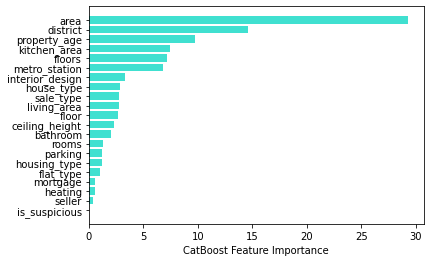

In [24]:
# важность признаков
sorted_feature_importance_cb = model_cb.feature_importances_.argsort()
plt.barh(X.columns[sorted_feature_importance_cb], 
        model_cb.feature_importances_[sorted_feature_importance_cb], 
        color='turquoise')
plt.xlabel("CatBoost Feature Importance")

In [25]:
# сохранение модели
with open('fitted_models/catboost_rs.pkl', 'wb') as f:
    pickle.dump(model_cb, f)